In [ ]:
#JULIEN VU

%matplotlib inline
!pip install geopandas
import requests
import pandas as pd
import geopandas as gpd
#import googlemaps
from scipy.spatial.distance import cdist

     |████████████████████████████████| 972kB 8.0MB/s 
     |████████████████████████████████| 14.8MB 331kB/s 
     |████████████████████████████████| 6.5MB 35.0MB/s 


In [ ]:
#mettre l'url vers san diego
#télécharger le fichier listings
urlistings = 'http://data.insideairbnb.com/united-states/'\
      'ca/san-diego/2016-07-07/data/'\
      'listings.csv.gz'
#accéder à l'url urllistings
r1 = requests.get(urlistings)
#ouvrir le fichier
with open('listings.csv.gz', 'wb') as fo:
    fo.write(r1.content)

In [ ]:
urlcalendar = 'http://data.insideairbnb.com/united-states/'\
      'ca/san-diego/2016-07-07/data/'\
      'calendar.csv.gz'
#accéder à l'url urlcalendar
r2 = requests.get(urlcalendar)
#ouvrir le fichier
with open('calendar.csv.gz', 'wb') as fo:
    fo.write(r2.content)

In [ ]:
urlneighbour = 'http://data.insideairbnb.com/united-states/'\
      'ca/san-diego/2016-07-07/visualisations/'\
      'neighbourhoods.geojson'
#accéder à l'url urlneighbour
r3 = requests.get(urlneighbour)
#ouvrir le fichier
with open('neighbourhoods.geojson', 'wb') as fo:
    fo.write(r3.content)

In [ ]:
#parser le prix

lst = pd.read_csv('listings.csv.gz')
lst['priceN'] = lst['price'].apply(
                    lambda x: float(str(x)\
                                    .replace(',', '')\
                                    .strip('$')))
lst['l_price'] = pd.np.log(lst['priceN'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


In [ ]:
#mettre en geodataframe
from shapely.geometry import Point
xys = lst[['longitude', 'latitude']]\
        .apply(lambda row: Point(*row), axis=1)
gdb = gpd.GeoDataFrame(lst.assign(geometry=xys),
                       crs="+init=epsg:4326")
print(gdb.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [ ]:
#colonne piscine et on affiche les équipements si pool se trouve dans pcs
ams = []
gdb['pool'] = 0
for i in range(gdb.shape[0]):
    r = gdb.loc[i, 'amenities']
    pcs = r.strip('{').strip('}').split(',')
    ams.extend(pcs)
    if 'Pool' in pcs:
        gdb.loc[i, 'pool'] = 1
set(ams)

{'',
 '"24-Hour Check-in"',
 '"Air Conditioning"',
 '"Buzzer/Wireless Intercom"',
 '"Cable TV"',
 '"Carbon Monoxide Detector"',
 '"Elevator in Building"',
 '"Family/Kid Friendly"',
 '"Fire Extinguisher"',
 '"First Aid Kit"',
 '"Free Parking on Premises"',
 '"Hair Dryer"',
 '"Hot Tub"',
 '"Indoor Fireplace"',
 '"Laptop Friendly Workspace"',
 '"Lock on Bedroom Door"',
 '"Other pet(s)"',
 '"Pets Allowed"',
 '"Pets live on this property"',
 '"Safety Card"',
 '"Smoke Detector"',
 '"Smoking Allowed"',
 '"Suitable for Events"',
 '"Wheelchair Accessible"',
 '"Wireless Internet"',
 '"translation missing: en.hosting_amenity_49"',
 '"translation missing: en.hosting_amenity_50"',
 'Breakfast',
 'Cat(s)',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'Essentials',
 'Gym',
 'Hangers',
 'Heating',
 'Internet',
 'Iron',
 'Kitchen',
 'Pool',
 'Shampoo',
 'TV',
 'Washer'}

In [ ]:
#trouver la localisation d'un lieu
from geopy.geocoders import Nominatim
geolocator = Nominatim()

/usr/local/lib/python3.6/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [ ]:
bp = geolocator.geocode("Balboa Park, San Diego, US")
bp

Location(Balboa Park, San Diego, San Diego County, California, United States, (32.73135675, -117.14652655570401, 0.0))

In [ ]:
#affichage de la latitude et de la longitude du parc balboa park
b_ll = bp.longitude, bp.latitude
b_ll

#latitude: -117.14652655570401
#longitude:  32.73135675

(-117.14652655570401, 32.73135675)

In [ ]:
# http://epsg.io/102003
tgt_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 "\
          "+lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"
#GeoSeries: série conçu pour stocker des objets de forme géométrique variable
#données b_ll en premier argument de GeoSeries et Coordinate Reference System of the geometry object en second argument
b_xy = gpd.GeoSeries(Point(b_ll), crs=gdb.crs).to_crs(tgt_crs)[0]
b_xy = (b_xy.x, b_xy.y)
# Calculate distance in Km.
d2b = lambda pt: cdist([(pt.x, pt.y)], [b_xy])[0][0] / 1000

Représentation géographique de la distance chaque maison au parc Balboa à San Diego:


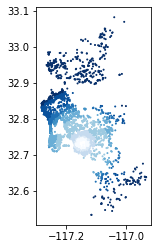

In [ ]:
!pip install mapclassify
import mapclassify
print('Représentation géographique de la distance chaque maison au parc Balboa à San Diego:')
gdb['d2balboa'] = gdb['geometry'].to_crs(tgt_crs)\
                                 .apply(d2b)
gdb.plot(column='d2balboa', scheme='quantiles', k=9,
         cmap='Blues', s=1)

Représentation des quartiers près de la mer à San Diego:


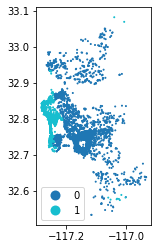

In [ ]:
#voisinage côtière

coastal_neighborhoods = ['Wooded Area', 'Ocean Beach', 'Pacific Beach', \
                         'La Jolla', 'Torrey Pines', 'Del Mar Heighs', \
                         'Mission Bay']

#méthode costal: dire si on est dans le quartier près de la mer
def coastal(neighb):
    if neighb in coastal_neighborhoods:
        return 1
    else:
        return 0
gdb['coastal_neig'] = gdb['neighbourhood_cleansed'].apply(coastal)
print('Représentation des quartiers près de la mer à San Diego:')
gdb.plot(column='coastal_neig', s=1,
         categorical=True, legend=True);

In [ ]:
#garder les observations dans les quartiers où il y a plus de 25 maisons AirBnb
lrg_nei = gdb.groupby('neighbourhood_cleansed').size() > 25
gdb['lrg_nei'] = gdb['neighbourhood_cleansed'].map(lrg_nei)
print(lrg_nei)
#West University Heights et balboa park enlevés de la list lrg_nei car possède moins de 25 maisons airbnb
#Allied Gardens,Alta Vista,Amphitheater And Water Park conservés dans la list lrg_nei

neighbourhood_cleansed
Allied Gardens                 False
Alta Vista                     False
Amphitheater And Water Park    False
Balboa Park                     True
Bario Logan                    False
                               ...  
Valencia Park                  False
Webster                        False
West University Heights         True
Wooded Area                    False
Yosemite Dr                    False
Length: 100, dtype: bool


In [ ]:
#liste xs à garder
xs = ['accommodates', 'bathrooms', 'bedrooms', 
      'beds', 'neighbourhood_cleansed', 'pool',
      'd2balboa', 'coastal_neig', 'lrg_nei',
      'priceN', 'l_price',
      'geometry', 'id']

In [ ]:
#type de chambre rt
roomt = pd.get_dummies(gdb['room_type'], prefix='rt').rename(columns=lambda x: x.replace(' ', '_'))
print(roomt.head(10))
#maison 0: chambre privee à garder
#maison 1: chambre privée
#maison 3: maison entière


   rt_Entire_home/apt  rt_Private_room  rt_Shared_room
0                   0                1               0
1                   0                1               0
2                   1                0               0
3                   1                0               0
4                   0                1               0
5                   0                1               0
6                   0                1               0
7                   0                1               0
8                   0                1               0
9                   1                0               0


In [ ]:
#type de propriété
def simplify(p):
    bigs = ['House', 'Apartment', 'Condominium', 'Townhouse']
    if p in bigs:
        return p
    else:
        return 'Other'

gdb['property_group'] = gdb['property_type'].apply(simplify)
pg = pd.get_dummies(gdb['property_group'], prefix='pg')
print(pg.head(10))

   pg_Apartment  pg_Condominium  pg_House  pg_Other  pg_Townhouse
0             0               0         1         0             0
1             0               1         0         0             0
2             0               1         0         0             0
3             0               0         0         0             1
4             0               0         1         0             0
5             0               0         1         0             0
6             0               0         1         0             0
7             0               0         1         0             0
8             0               0         1         0             0
9             0               0         1         0             0
